In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sn
from pulp import *

In [20]:

#a handful of sites
#sites = ['30000214','30013206','30030524','30033181','30033350','30033458','30033086','30022796','30031162','30025126','30031901','30029639','30025720','30019783','30030663','30008705','30031098','30032767']
sites = ['Barcelona','Belgrade','Berlin','Brussels','Bucharest','Budapest','Copenhagen','Dublin','Hamburg','Istanbul','Kiev','London','Madrid','Milan','Moscow','Munich','Paris','Prague','Rome','Saint Petersburg','Sofia','Stockholm','Vienna','Warsaw']
# sites = ['Barcelona','Belgrade','Berlin','Brussels','Bucharest','Budapest','Copenhagen']
latlng = ['latitude', 'longitude']
position = pd.read_csv('./data/position.csv', index_col="City")
#position=pd.read_excel(r'C:\Users\bazrekar\pythonclass\Position.xlsx', index_col="City")
distance = pd.read_csv('./data/dis.csv', index_col="City")
#distance=pd.read_excel(r'C:\Users\bazrekar\pythonclass\dis.xlsx', index_col="City")
position.head(5)
# print(len(sites))


,latitude,longitude
City,,
Barcelona,41.3888,2.1590
Belgrade,44.8040,20.4651
Berlin,52.5244,13.4105
Brussels,50.8505,4.3488
Bucharest,44.4323,26.1063


In [21]:
#make some positions (so we can plot this)
positions = dict( ( City, (position.loc[City,'longitude'], position.loc[City,'latitude']) ) for City in sites)

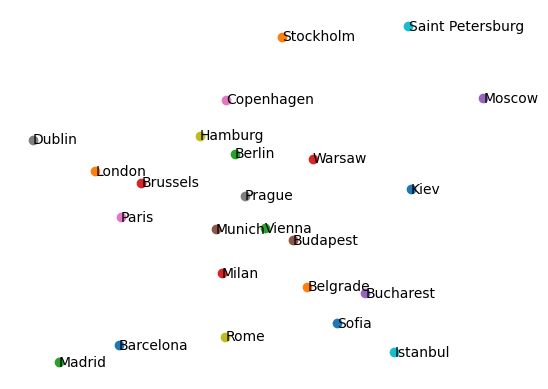

In [22]:
for s in positions:
    p = positions[s]
    plt.plot(p[0],p[1],'o')
    plt.text(p[0]+.01,p[1],s,horizontalalignment='left',verticalalignment='center')
plt.gca().axis('off');

In [23]:
# get distanc between cities
distances = dict( ((s1,s2), distance.loc[s1, s2] ) for s1 in positions for s2 in positions if s1!=s2)

In [24]:
K = 2  #the number of car 

In [25]:
#pip install pulp 

In [26]:

#create the problme
prob=LpProblem("vehicle", LpMinimize)

In [27]:
#indicator variable if site i is connected to site j in the tour
x = LpVariable.dicts('x',distances, 0,1,LpBinary)
#dummy vars to eliminate subtours
u = LpVariable.dicts('u', sites, 0, len(sites)-1, LpInteger)

In [28]:
#the objective
cost = lpSum([x[(i,j)]*distances[(i,j)] for (i,j) in distances])
prob+=cost

In [29]:
#constraints
for k in sites:
    cap = 1 if k != 'Berlin' else K
    #inbound connection
    prob+= lpSum([ x[(i,k)] for i in sites if (i,k) in x]) ==cap
    #outbound connection
    prob+=lpSum([ x[(k,i)] for i in sites if (k,i) in x]) ==cap
    
#subtour elimination
N=len(sites)/K
for i in sites:
    for j in sites:
        if i != j and (i != 'Berlin' and j!= 'Berlin') and (i,j) in x:
            prob += u[i] - u[j] <= (N)*(1-x[(i,j)]) - 1

In [30]:
%time prob.solve()
#prob.solve(GLPK_CMD(options=['--simplex']))
print(LpStatus[prob.status])

Wall time: 4.42 s
Optimal


In [31]:
non_zero_edges = [ e for e in x if value(x[e]) != 0 ]

def get_next_site(parent):
    '''helper function to get the next edge'''
    edges = [e for e in non_zero_edges if e[0]==parent]
    for e in edges:
        non_zero_edges.remove(e)
    return edges

In [32]:
tours = get_next_site('Berlin')
tours = [ [e] for e in tours ]

for t in tours:
    while t[-1][1] !='Berlin':
        t.append(get_next_site(t[-1][1])[-1])

In [33]:
for t in tours:
    print(' -> '.join([ a for a,b in t]+['Berlin']))

Berlin -> Copenhagen -> Stockholm -> Saint Petersburg -> Moscow -> Kiev -> Bucharest -> Istanbul -> Sofia -> Belgrade -> Budapest -> Vienna -> Warsaw -> Berlin
Berlin -> Prague -> Munich -> Milan -> Rome -> Barcelona -> Madrid -> Dublin -> London -> Paris -> Brussels -> Hamburg -> Berlin


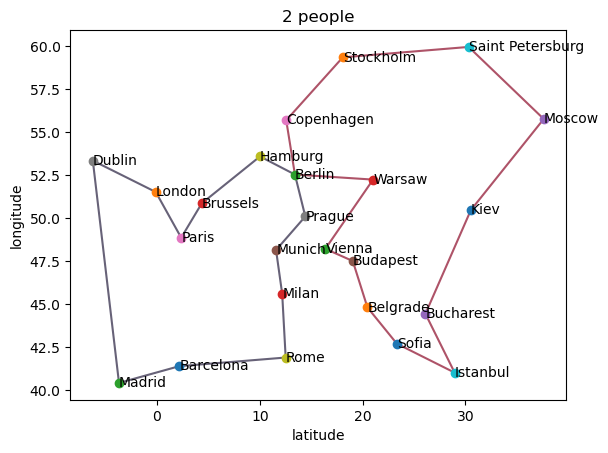

In [34]:
#draw the tours
colors = [np.random.rand(3) for i in range(len(tours))]
for t,c in zip(tours,colors):
    for a,b in t:
        p1,p2 = positions[a], positions[b]
        plt.plot([p1[0],p2[0]],[p1[1],p2[1]], color=c)

#draw the map again
for s in positions:
    p = positions[s]
    plt.plot(p[0],p[1],'o')
    plt.text(p[0]+.01,p[1],s,horizontalalignment='left',verticalalignment='center')
    
plt.title('%d '%K + 'people' if K > 1 else 'person')
plt.xlabel('latitude')
plt.ylabel('longitude')
# plt.gca().axis('off')
plt.show()

In [35]:
print('Total distance:', value(prob.objective), '(km)')

Total distance: 12607.64 (km)
